In [1]:
import re
import pandas as pd
import numpy as np
# data_root = './Anonymized_644.Updated_cleaned_v1.3.2.tsv'
data_root = './anonymized_644.csv'
adjacency_file = './connectivity_646.csv'
cluster_root = 'ln_Data_and_clusters.csv'
validation_file = 'validation_data.xlsx'
radiomic_cluster_file = 'hp_updated_clusters.csv'

In [2]:
#Adajacency is an adjacency matrix in csv form. 1 means the row-column is connected, 2 is not
#Diagonals are always a 1
adjacency = pd.read_csv(adjacency_file)
adjacency

,1A,1B,2A,2B,3,4,5A,5B,6,RPLN
1A,1,1,0,0,0,0,0,0,1,0
1B,1,1,1,0,1,0,0,0,0,0
2A,0,1,1,1,1,0,0,0,0,0
2B,0,0,1,1,0,0,1,0,0,0
3,0,1,1,0,1,1,1,0,1,0
4,0,0,0,0,1,1,0,1,1,0
5B,0,0,0,1,1,0,1,1,0,0
5B,0,0,0,0,0,1,1,1,0,0
6,1,0,0,0,1,1,0,0,1,0
RPLN,0,0,0,0,0,0,0,0,0,1


In [4]:
#Load the Data
df = pd.read_csv(data_root)
df.head()

,Dummy ID,ROI,Age at Diagnosis (Calculated),Pathological Grade,Gender,Race,Therapeutic combination,Tm Laterality (R/L),Tumor subsite (BOT/Tonsil/Soft Palate/Pharyngeal wall/GPS/NOS),Affected Lymph node UPPER,...,Total dose,Total fractions,Treatment duration (Days),Dose/fraction (Gy),Feeding tube 6m,Aspiration rate Pre-therapy,Aspiration rate Post-therapy,Aspiration rate(Y/N),Aspiration type,N_category_full
0,1,NaN,57.019444,III,Male,White/Caucasion,CC,R,Tonsil,"R2, R3",...,66.00,30,42.0,2.200000,N,N,N,N,NaN,N2b
1,2,GTVp1,55.855556,III,Female,White/Caucasion,CC,R,BOT,R2,...,66.00,30,45.0,2.200000,N,N,N,N,NaN,N2b
2,3,GTVp1,60.222222,II,Female,White/Caucasion,CC,L,Tonsil,"L2, L3",...,70.00,33,54.0,2.121212,N,N,N,N,NaN,N2b
3,4,GTVp1,66.344444,III,Male,White/Caucasion,CC,R,BOT,R2,...,66.00,30,39.0,2.200000,N,N,N,N,NaN,N1
4,5,NaN,49.733333,II,Male,White/Caucasion,CC,R,BOT,R3,...,69.96,33,44.0,2.120000,N,N,N,N,NaN,N2a


In [5]:
#Lymph nodes are marked as a list in the columns in this dataset
#In the data R and L denote left and right sides of the head
df['Affected Lymph node UPPER'].loc[0:3]

0    R2, R3
1        R2
2    L2, L3
3        R2
Name: Affected Lymph node UPPER, dtype: object

In [6]:
#clean up the data and drop peopel with no affected nodes
df = df.rename(columns={'Affected Lymph node UPPER':'affected_nodes'}).dropna(subset=['affected_nodes'])
df.affected_nodes.loc[3:7]

3        R2
4        R3
5    R2, R3
6    R2, L3
7        L2
Name: affected_nodes, dtype: object

In [7]:
left_nodes = sorted(['L'+n for n in adjacency.columns])
right_nodes = sorted(['R'+n for n in adjacency.columns])
rpln = ['RRPLN', 'LRPLN'] #I don't think we use these as they're not in the head but they were in the original cluster paper
nodes = left_nodes + right_nodes
node_to_index = {word: position for position, word in enumerate(nodes)}
node_to_index

{'L1A': 0,
 'L1B': 1,
 'L2A': 2,
 'L2B': 3,
 'L3': 4,
 'L4': 5,
 'L5A': 6,
 'L5B': 7,
 'L6': 8,
 'LRPLN': 9,
 'R1A': 10,
 'R1B': 11,
 'R2A': 12,
 'R2B': 13,
 'R3': 14,
 'R4': 15,
 'R5A': 16,
 'R5B': 17,
 'R6': 18,
 'RRPLN': 19}

In [8]:
#Nodes are saved as a string in the data so this converts them into a list of values 
def parse_lymph_nodes(node_string,all_nodes):
    #weird edge case in one of the datasets
    node_string = re.sub('2/3', '2A', node_string)
    #the data apparently has just '2' when theres a '2A' and '2B'
    node_string = re.sub('([L,R])([2,5]),+','\g<1>\g<2>A, \g<1>\g<2>B,', node_string)
    node_string = re.sub('([L,R])([2,5])$','\g<1>\g<2>A, \g<1>\g<2>B', node_string)
    node_string = re.sub('R RPLN', 'RRPLN', node_string)
    node_string = re.sub('L RPLN', 'LRPLN', node_string)
    nodes = [n.strip().upper() for n in node_string.split(',')]
    #remove the node with 'in-between' labeled nodes?
    ambiguous_nodes = set(['2/3','3/4','2/3/4','/3','2/','-R4'])
    for n in nodes:
        if n in ambiguous_nodes:
            return np.NaN
    nodes = [n for n in nodes if n in all_nodes]
    if len(nodes) <= 0:
        return np.NaN
    return sorted(nodes)
df['nodes'] = df.affected_nodes.apply(lambda x: parse_lymph_nodes(x,nodes))
df = df.dropna(subset=['nodes'])
df.nodes.iloc[0]

['R2A', 'R2B', 'R3']

In [9]:
def get_monograms(data,nodenames):
    
    monograms = pd.DataFrame(index = data.index, columns = nodenames, dtype = np.int32).fillna(0)
    for pos, p in enumerate(data['nodes']):
        index = data.index[pos]
        for lymph_node in p:
            monograms.loc[index, lymph_node] = 1
    return monograms
monograms = get_monograms(df,nodes)
monograms.head()

,L1A,L1B,L2A,L2B,L3,L4,L5A,L5B,L6,LRPLN,R1A,R1B,R2A,R2B,R3,R4,R5A,R5B,R6,RRPLN
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [10]:
def clean_names(x):
    return [re.sub('^[LR]\s*','',x) for x in x.columns]

def clean_names_string(x):
    return ''.join(clean_names(x))

#convert the monograms into a single value that is 0-2 for both sides
dm_values = monograms.loc[:,left_nodes].values + monograms.loc[:,right_nodes].values
dual_monograms = pd.DataFrame(dm_values, columns = clean_names(monograms.loc[:,left_nodes]), index=monograms.index)
dual_monograms.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2A,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0
2B,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0
3,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
5A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RPLN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
def get_bigram_names(adjacency):
    node_list = sorted(adjacency.columns)
    bigram_set = set([])

    for i, name in enumerate(node_list):
        for i2 in range(i+1, len(node_list)):
            if adjacency.iloc[i,i2] > 0:
                bigram_set.add(name + node_list[i2])
    ' '.join(sorted(bigram_set))
    bigram_names = (sorted(bigram_set))
    return bigram_names, bigram_set

def bigramize(v, side,adjacency):
    #shoudl take a unilateral (left or right) matrix of affected lypmh nnodes
    assert(v.shape[1] == adjacency.shape[1])
    
    col_names = list(v.columns)
    clean = lambda x:  re.sub('^[LR]\s*','', x)
    bigrams = []
    names = []
    _, bigram_set = get_bigram_names(adjacency)
    for i, colname in enumerate(col_names):
        nodename = clean(colname)
        for i2 in range(i+1, v.shape[1]):
            colname2 = col_names[i2]
            bigram_name = nodename + clean(colname2)
            if bigram_name in bigram_set:
                if bigram_name not in names:
                    names.append(side + bigram_name)
                bigram_vector = (v[colname].values + v[colname2].values)
                bigrams.append(bigram_vector.reshape(-1,1))
    return pd.DataFrame(np.hstack(bigrams), columns = names, index = v.index)

#convert get bigrams (when both adjacent values are affected) and convert to matrix that is 0-2 for both sides also
left_bigrams = bigramize(monograms.loc[:,left_nodes],'L',adjacency,)
right_bigrams = bigramize(monograms.loc[:,right_nodes],'R',adjacency,)
lnames = clean_names_string(left_bigrams)
rnames = clean_names_string(right_bigrams)
dual_bigrams = pd.DataFrame(left_bigrams.values +right_bigrams.values, 
                               columns = clean_names(left_bigrams),
                               index = df.index)
dual_bigrams.head().T

,0,1,2,3,4
1A1B,0.0,0.0,0.0,0.0,0.0
1A6,0.0,0.0,0.0,0.0,0.0
1B2A,1.0,1.0,1.0,1.0,0.0
1B3,1.0,0.0,1.0,0.0,1.0
2A2B,2.0,2.0,2.0,2.0,0.0
2A3,2.0,1.0,2.0,1.0,1.0
2B5A,1.0,1.0,1.0,1.0,0.0
34,1.0,0.0,1.0,0.0,1.0
35A,1.0,0.0,1.0,0.0,1.0
36,1.0,0.0,1.0,0.0,1.0


<Axes: ylabel='Frequency'>

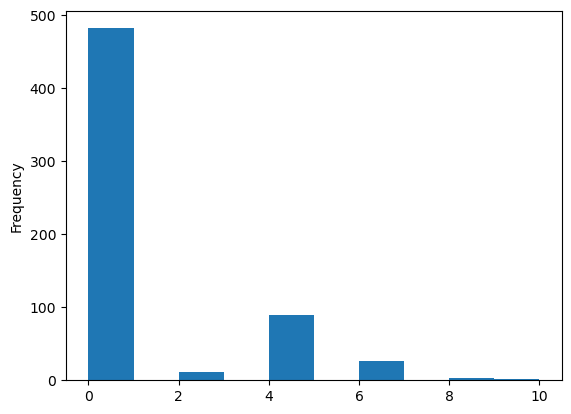

In [12]:
#add number of bilateral nodes as a feature also
bilateral_bonus = dual_monograms.copy().apply(lambda l: np.sum([x for x in l if x > 1]), axis = 1)
bilateral_bonus.plot(kind='hist')

In [13]:
#maximum distance between sets of nodes.  Limited to current cohort valid options (2A and 2B always co-occur)
SPREAD_DICT = {
    '1A1B': 1,
    '1A2A': 1,
    '1A2B': 3,
    '1A3': 2,
    '1A4': 2,
    '1A5A': 3,
    '1A5B': 3,
    '1A1B': 1,
    '1B2A': 1,
    '1B2B': 2,
    '1B4': 3,
    '1B3': 2,
    '1B5A': 3,
    '1B5B': 4,
    '2A2B': 1,
    '2A3': 1,
    '2A5A': 2, #2B is only closer to 5A than 2A so we can skip everything else
    '2B2A': 1,
    '2B3': 2,
    '2B4': 3,
    '2B5A': 1,
    '2B5B': 2, 
    '34': 1,
    '35A':1,
    '35B': 2,
    '45A': 2,
    '45B': 1
}
    
def ln_spread(laterality, nodes,spread_dict):
    if len(nodes) == 0:
        return 0, 0
    pattern = '^[LR]\s*'
    is_bilateral = False
    if laterality == 'Bilateral':
        is_bilateral = True
        laterality = 'L' #bilateral should be treated as a special case were both part sare contralateral
    ipsilateral = [re.sub(pattern,'',n) for n in nodes if n[0] in laterality]
    contralateral = [re.sub(pattern,'',n) for n in nodes if n[0] not in laterality]
    ips_spread = lateral_spread(ipsilateral,spread_dict,False)
    contra_spread = lateral_spread(contralateral,spread_dict,False)
    if is_bilateral:
        max_spread = np.max([ips_spread, contra_spread])
        min_spread = np.min([ips_spread, contra_spread])
        return max_spread, min_spread
    return ips_spread, contra_spread
    
def lateral_spread(nodes, spread_dict,clean = True):
    max_dist = 0
    if clean:
        nodes = [re.sub('^[LR]\s*','',n) for n in nodes]
    if len(nodes) == 1:
        return 0
    nodes = sorted(nodes)
    max_value = max(spread_dict.values())
    for i in range(len(nodes) - 1):
        for ii in range(i, len(nodes)):
            pair = nodes[i] + nodes[ii]
            if pair in spread_dict:
                new_dist = spread_dict[pair]
                if new_dist > max_dist:
                    max_dist = new_dist
                    if max_dist == max_value:
                        break
    if 'RPLN' in nodes: #idk add more spread if this is here?
        max_dist += 1
    return max_dist

def node_spread(df, spread_dict,to_dataframe = True, max_ips = 2, max_contra = 4):
    node_df = df.loc[:,['Tm Laterality (R/L)','nodes']]
    spread = node_df.apply(lambda x: ln_spread(x[0],x[1],spread_dict),axis=1).values
    spread = np.array(list(spread))
    spread = np.array([max_ips, max_contra])*spread/spread.max(axis=0)
    if to_dataframe:
        spread = pd.DataFrame(spread, columns = ['ips_spread','contra_spread'], index = df.index.values)
        spread.index.name = df.index.name
    return spread

#get a normalzied score for the exents of the tumor spread. Spread dict is a manual mapping of the inter-ln node distances
node_spread(df,SPREAD_DICT)

,ips_spread,contra_spread
0,0.8,0.000000
1,0.4,0.000000
2,0.8,0.000000
3,0.4,0.000000
4,0.0,0.000000
...,...,...
638,0.4,0.000000
640,0.8,0.000000
641,0.0,1.333333
642,0.4,0.000000


In [14]:
# for inputs you can test combinations of monograms, bigrams, and ln_spread features
spatial_df = pd.concat([dual_monograms,dual_bigrams,bilateral_bonus,node_spread(df,SPREAD_DICT)],axis=1)
spatial_df.head()

,1A,1B,2A,2B,3,4,5A,5B,6,RPLN,...,2B5A,34,35A,36,45B,46,5A5B,0,ips_spread,contra_spread
0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.8,0.0
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0
2,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.8,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
#custom heirarichical clustering model
from sklearn.base import ClusterMixin, BaseEstimator
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
from scipy.spatial.distance import pdist
from scipy.spatial.distance import canberra

def tanimoto_dist(x1, x2):
    if l1(x1, x2) == 0:
        return 0
    tanimoto = x1.dot(x2)/(x1.dot(x1) + x2.dot(x2) - x1.dot(x2))
    #guadalupe used 1 - similarity for her clustering
    return 1/(1+tanimoto)

class AClusterer(ClusterMixin, BaseEstimator):

    def __init__(self, 
                 n_clusters, 
                 dist_func = tanimoto_dist, 
                 link = 'weighted', 
                 criterion = 'maxclust', 
                 square_dist = False):
        self.link = link
        self.dist_func = dist_func 
        self.t = n_clusters
        self.square_d = square_dist
        self.criterion = criterion
        
    def get_leaves(self, x):
        clusters = linkage(x, method = self.link, metric = self.dist_func, optimal_ordering = True)
        dendro = dendrogram(clusters)
        return np.array(dendro['leaves']).astype('int32')
    
    def fit_predict(self, x, y = None):
        dists = pdist(x,metric = self.dist_func)
        if self.square_d:
            dists = dists**2
        clusters = linkage(dists, method = self.link, metric = self.dist_func, optimal_ordering = True)
        return fcluster(clusters, self.t, criterion = self.criterion)

In [19]:
def get_pattern_clusters(vectors, k=4, normalize = True, square_dist = True):
#     vectors.loc[:,'bilateral'] = vectors.bilateral.values/2
    if normalize:
        vectors = vectors.loc[:, vectors.std() > 0]
        vectors = (vectors - vectors.mean())/vectors.std()
    patterns = np.unique(vectors.values,axis=0)
    clusterer = AClusterer(k, dist_func = canberra, link = 'ward', square_dist = square_dist)
    temp_clusters = clusterer.fit_predict(patterns)
    mapped_clusters = np.zeros((vectors.shape[0],))
    for p,c in zip(patterns, temp_clusters):
        for v in range(vectors.shape[0]):
            if np.array_equal(vectors.values[v],p):
                mapped_clusters[v] = c
    return pd.DataFrame(mapped_clusters.astype('int32'), index = vectors.index, columns =['cluster'])
#cluster labels
get_pattern_clusters(spatial_df)

,cluster
0,3
1,4
2,3
3,4
4,3
...,...
638,4
640,3
641,4
642,4
